# Run analysis

Imagine we want to measure student achievement and growth in seventh grade. We have data that follow students from sixth to seventh grade and describe their demographic characteristics and exit exam scores in core subjects. This notebook walks through common data analysis tasks on an example clean dataset. The code explores relationships in the data with plots, tables, and regressions.

In [1]:
# Load packages.
library(dplyr)
library(tidyr)
library(ggplot2)
library(broom)
library(openxlsx)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Identify inputs and outputs.
PWD <- file.path(getwd(), "..")
DTA <- file.path(PWD, "out", "data.rda")
FIG <- file.path(PWD, "out", "plot.png")
OUT <- file.path(PWD, "out", "analysis.xlsx")

In [3]:
# Read long and wide analysis files.
# This loads the two datasets we created into the same namespaces.
load(DTA)
head(stu_sch_long)
head(stu_sch_wide)

sy,stuid,schid,grade,dob,gender_old,race,iep,math,ela,⋯,hispanic,white,gender,male,female,gender_na,is_dup,school_name,frpl,enrl
<dbl>,<int>,<chr>,<int>,<date>,<chr>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<fct>,<dbl>,<dbl>,<int>,<lgl>,<chr>,<dbl>,<dbl>
2018,1,A,6,2007-08-05,2,Black,1,63,60,⋯,0,0,Female,0,1,0,FALSE,Yuri Andropov Middle School,0.34,412
2018,2,A,6,2007-02-26,1,Hispanic,0,86,91,⋯,1,0,Male,1,0,0,FALSE,Yuri Andropov Middle School,0.34,412
2018,3,A,6,2007-03-13,1,Black,1,68,83,⋯,0,0,Male,1,0,0,FALSE,Yuri Andropov Middle School,0.34,412
2018,4,A,6,2006-11-07,2,White,0,77,86,⋯,0,1,Female,0,1,0,FALSE,Yuri Andropov Middle School,0.34,412
2018,5,A,6,2007-04-15,2,White,0,89,95,⋯,0,1,Female,0,1,0,FALSE,Yuri Andropov Middle School,0.34,412
2018,6,A,6,2007-04-18,2,Hispanic,1,61,52,⋯,1,0,Female,0,1,0,FALSE,Yuri Andropov Middle School,0.34,412


stuid,schid,dob,gender_old,race,asian,black,hispanic,white,gender,⋯,sci_6,sci_7,soc_6,soc_7,oss_6,oss_7,frpl_6,frpl_7,enrl_6,enrl_7
<int>,<chr>,<date>,<chr>,<fct>,<int>,<int>,<int>,<int>,<fct>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A,2007-08-05,2,Black,0,1,0,0,Female,⋯,57,56,62,NA,0,0,0.34,0.35,412,399
2,A,2007-02-26,1,Hispanic,0,0,1,0,Male,⋯,53,53,87,NA,0,0,0.34,0.35,412,399
3,A,2007-03-13,1,Black,0,1,0,0,Male,⋯,54,53,74,NA,0,0,0.34,0.35,412,399
4,A,2006-11-07,2,White,0,0,0,1,Female,⋯,51,51,84,NA,0,0,0.34,0.35,412,399
5,A,2007-04-15,2,White,0,0,0,1,Female,⋯,57,56,93,NA,0,0,0.34,0.35,412,399
6,A,2007-04-18,2,Hispanic,0,0,1,0,Female,⋯,57,58,57,NA,0,0,0.34,0.35,412,399


Warning message:
"Removed 16 rows containing missing values (`geom_point()`)."


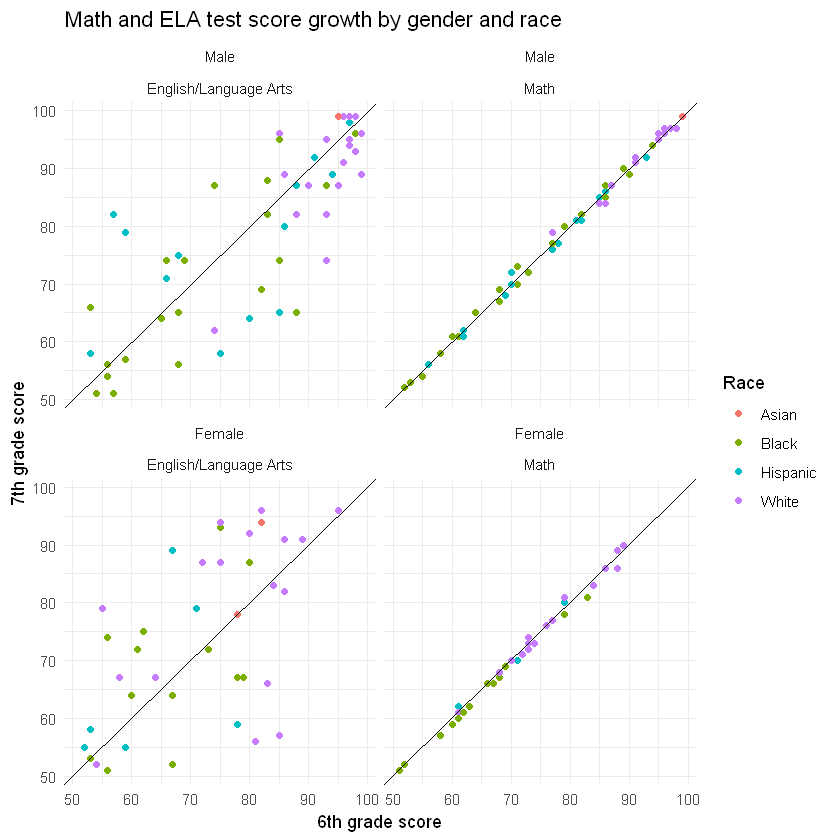

In [4]:
# Plot test scores by race.
# Transform data so that each point on the plot is a separate row.
stu_sch_long |>
  select(stuid, grade, gender, race, math, ela) |>
  filter(!is.na(gender)) |>
  # Reshape long on test subject.
  pivot_longer(
    cols = c(math, ela),
    names_to = "test_subj",
    values_to = "test_val"
  ) |>
  # Reshape wide on grade.
  pivot_wider(
    names_from = grade,
    names_prefix = "grade_",
    values_from = test_val
  ) |>
  # Draw plot.
  ggplot(aes(x = grade_6, y = grade_7, color = race)) +
  geom_point() +
  geom_abline() +
  facet_wrap(
    facets = vars(gender, test_subj),
    labeller = labeller(test_subj = as_labeller(c(
      "math" = "Math",
      "ela" = "English/Language Arts"
    )))
  ) +
  labs(
    title = "Math and ELA test score growth by gender and race",
    x = "6th grade score",
    y = "7th grade score",
    color = "Race"
  ) +
  theme_minimal()

In [5]:
# Save the figure.
ggsave(FIG)

Saving 6.67 x 6.67 in image
Warning message:
"Removed 16 rows containing missing values (`geom_point()`)."


In [6]:
# Calculate unadjusted means by grade and gender.
tab1 <- stu_sch_long |>
  group_by(grade, female) |>
  summarize(across(c(math, ela, sci, soc), ~ mean(.x, na.rm = TRUE)))
tab1

`summarise()` has grouped output by 'grade'. You can override using the
`.groups` argument.


grade,female,math,ela,sci,soc
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,0,80.68421,81.33333,59.35088,80.38596
6,1,71.58974,71.43590,55.66667,70.61538
7,0,80.89474,80.05263,59.22807,NaN
7,1,71.51282,74.05128,55.64103,NaN


In [7]:
# Estimate differences in math scores by gender, conditional on prior scores.
# Growth among students classified as female decreased by 0.5 points on average.
# Results are statistically different from zero at the 5% level.
reg1 <- lm(math_7 ~ female + math_6, data = stu_sch_wide)
summary(reg1)


Call:
lm(formula = math_7 ~ female + math_6, data = stu_sch_wide)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0445 -0.8300 -0.0238  0.4161  2.1228 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.351400   0.618863  -0.568    0.572    
female      -0.135056   0.206720  -0.653    0.515    
math_6       1.004604   0.007542 133.204   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9224 on 89 degrees of freedom
  (8 observations deleted due to missingness)
Multiple R-squared:  0.9956,	Adjusted R-squared:  0.9955 
F-statistic:  9972 on 2 and 89 DF,  p-value: < 2.2e-16


In [8]:
# Set the reference group in the race category to White.
stu_sch_wide$race <- relevel(stu_sch_wide$race, ref = "White")

# Estimate differences in ELA scores by race, conditional on prior scores.
# Disparities in growth are not statistically different from zero.
reg2 <- lm(ela_7 ~ race + ela_6, data = stu_sch_wide)
summary(reg2)


Call:
lm(formula = ela_7 ~ race + ela_6, data = stu_sch_wide)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.2865  -5.8714   0.3553   6.9878  19.9361 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  28.41799    7.32532   3.879 0.000203 ***
raceAsian     9.32850    5.50572   1.694 0.093780 .  
raceBlack    -4.64987    2.82074  -1.648 0.102866    
raceHispanic -2.85929    3.06495  -0.933 0.353454    
ela_6         0.65728    0.08358   7.864 9.34e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 10.39 on 87 degrees of freedom
  (8 observations deleted due to missingness)
Multiple R-squared:  0.5427,	Adjusted R-squared:  0.5217 
F-statistic: 25.81 on 4 and 87 DF,  p-value: 4.073e-14


In [9]:
# Collect regression output.
regs <- list("math_female" = reg1, "ela_race" = reg2) |>
  lapply(tidy) |>
  bind_rows(.id = "model")

# Save tabulation and regression output to Excel.
ws <- list("summaries" = tab1, "models" = regs)
write.xlsx(ws, OUT)